In [1]:
from google.colab import files # Для работы с файлами 
import numpy as np # Для работы с данными 
import pandas as pd # Для работы с таблицами
import matplotlib.pyplot as plt # Для вывода графиков
import os # Для работы с файлами
%matplotlib inline

from tensorflow.keras import utils # Для работы с категориальными данными
from tensorflow.keras.models import Sequential # Полносвязная модель
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Dropout, Conv1D# Слои для сети
from tensorflow.python.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers import Adam, Adadelta # Алгоритмы оптимизации, для настройки скорости обучения
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями

from sklearn.preprocessing import LabelEncoder # Метод кодирования тестовых лейблов
from sklearn.model_selection import train_test_split # Для разделения выборки на тестовую и обучающую
from google.colab import drive # Для работы с Google Drive
import time # Импортируем библиотеку time

import pandas as pd
import numpy as np

from tensorflow.keras.layers import GlobalMaxPooling1D, Bidirectional , LSTM, Input, MaxPooling1D
from tensorflow.keras.models import Model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!rm -R /content/texts # Проверяем наличие папки texts. Если есть, удаляем ее


In [4]:
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/datasets/texts/Тексты писателей.zip' -d '/content/texts'

In [5]:
# Запускаем все необходимые функции

def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample

# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку
  
  return (xSamples, ySamples) # Функция возвращает выборку и соответствующие векторы классов

# Создаем функцию подготовки данных
def creat_train_data(maxWordsCount = 15000, xLen = 1000, step = 100):
    tokenizer = Tokenizer(num_words=maxWordsCount)
    tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

    # Преобразовываем текст в последовательность индексов согласно частотному словарю
    trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
    testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

    #Формируем обучающую и тестовую выборку
    xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
    xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

    # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
    xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
    xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

    return xTrain, xTrain01, yTrain, xTest, xTest01, yTest

#Загружаем обучающие тексты

trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку
(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку
(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку



In [6]:
# Создаем функцию подготовки данных
def creat_train_data(maxWordsCount = 15000, xLen = 1000, step = 100):
    tokenizer = Tokenizer(num_words=maxWordsCount)
    tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности

    # Преобразовываем текст в последовательность индексов согласно частотному словарю
    trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
    testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

    #Формируем обучающую и тестовую выборку
    xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
    xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

    # Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
    xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
    xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

    return xTrain, xTrain01, yTrain, xTest, xTest01, yTest

In [7]:
_, xTrain01, yTrain, _, xTest01, yTest = creat_train_data(maxWordsCount = 15000, xLen = 1000, step = 100)

In [8]:
maxWordsCount = 15000 # Определяем максимальное количество слов/индексов, учитываемое при обучении текстов

# Указываем что нет фильтрации
tokenizer = Tokenizer(num_words=maxWordsCount, filters = '') 
tokenizer.fit_on_texts(trainText) # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы

#Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы

#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку

# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

# Выводим формы масивов
print(xTrain01.shape)
print(yTrain.shape)
print(xTest01.shape)
print(yTest.shape)

(13531, 15000)
(13531, 6)
(4819, 15000)
(4819, 6)


In [ ]:
tokenizer.word_index

In [10]:
#Задаём базовые параметры
xLen = 1000 # Длина отрезка текста, по которой анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы

#Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) #извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    #извлекаем тестовую выборку
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(13531, 1000)
(13531, 6)
(4819, 1000)
(4819, 6)


In [11]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrain01 = tokenizer.sequences_to_matrix(xTrain.tolist()) # Подаем xTrain в виде списка, чтобы метод успешно сработал
xTest01 = tokenizer.sequences_to_matrix(xTest.tolist())   # Подаем xTest в виде списка, чтобы метод успешно сработал

print(xTrain01.shape)       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrain01[0][0:100])   # Фрагмент набора слов в виде Bag of Words

(13531, 15000)
[0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 1. 0.]


In [12]:
for i in range(100):
  print(int(i in xTrain[0]),end=' ')

0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 

Epoch 1/45
1692/1692 [==============================] - 5s 3ms/step - loss: 0.1157 - accuracy: 0.9722 - val_loss: 0.2819 - val_accuracy: 0.9276
Epoch 2/45
1692/1692 [==============================] - 5s 3ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2422 - val_accuracy: 0.9305
Epoch 3/45
1692/1692 [==============================] - 5s 3ms/step - loss: 3.3904e-04 - accuracy: 1.0000 - val_loss: 0.2147 - val_accuracy: 0.9346
Epoch 4/45
1692/1692 [==============================] - 5s 3ms/step - loss: 1.2380e-04 - accuracy: 1.0000 - val_loss: 0.2094 - val_accuracy: 0.9299
Epoch 5/45
1692/1692 [==============================] - 5s 3ms/step - loss: 4.6635e-05 - accuracy: 1.0000 - val_loss: 0.1871 - val_accuracy: 0.9361
Epoch 6/45
1692/1692 [==============================] - 5s 3ms/step - loss: 1.8858e-05 - accuracy: 1.0000 - val_loss: 0.1870 - val_accuracy: 0.9338
Epoch 7/45
1692/1692 [==============================] - 5s 3ms/step - loss: 9.1603e-06 - accuracy: 1.0000 - val_loss: 0.

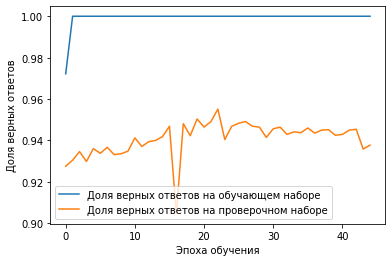

In [14]:
# Полносвязная модель

model = Sequential()
model.add(Dense(200, input_dim=maxWordsCount, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(6, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(xTrain01, 
                      yTrain, 
                      epochs=45,
                      batch_size=8,
                      validation_data=(xTest01, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Epoch 1/15
423/423 [==============================] - 16s 38ms/step - loss: 0.2124 - accuracy: 0.9217 - val_loss: 5.8525 - val_accuracy: 0.3731
Epoch 2/15
423/423 [==============================] - 16s 37ms/step - loss: 0.0273 - accuracy: 0.9942 - val_loss: 1.3096 - val_accuracy: 0.8303
Epoch 3/15
423/423 [==============================] - 16s 37ms/step - loss: 0.0310 - accuracy: 0.9939 - val_loss: 4.8848 - val_accuracy: 0.6037
Epoch 4/15
423/423 [==============================] - 16s 37ms/step - loss: 0.0297 - accuracy: 0.9958 - val_loss: 2.0264 - val_accuracy: 0.8041
Epoch 5/15
423/423 [==============================] - 16s 37ms/step - loss: 0.0318 - accuracy: 0.9959 - val_loss: 3.2985 - val_accuracy: 0.7253
Epoch 6/15
423/423 [==============================] - 16s 37ms/step - loss: 0.0184 - accuracy: 0.9974 - val_loss: 3.3785 - val_accuracy: 0.7111
Epoch 7/15
423/423 [==============================] - 16s 37ms/step - loss: 0.0217 - accuracy: 0.9970 - val_loss: 2.1341 - val_accuracy:

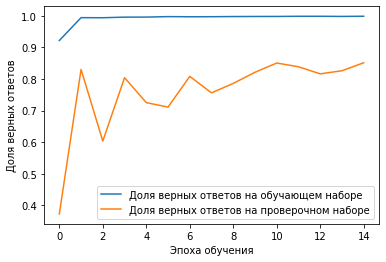

In [50]:
# Embedding + Conv1D модель

model = Sequential()
model.add(Embedding(maxWordsCount, 200, input_length = xLen))

model.add(Conv1D(256, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

history = model.fit(xTrain, 
                      yTrain, 
                      epochs=15,
                      batch_size=32,
                      validation_data=(xTest, yTest))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()


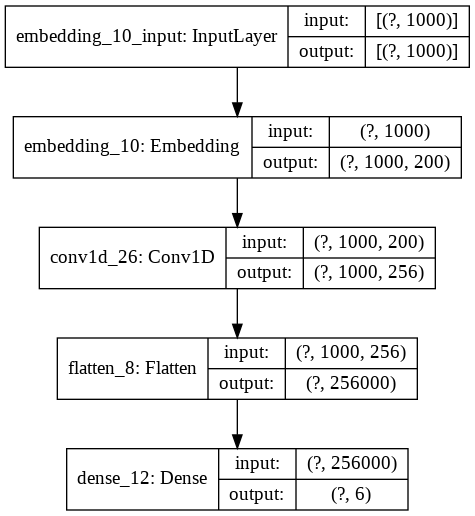

In [51]:
from keras.utils import plot_model
import sklearn
from sklearn.metrics import precision_recall_fscore_support as score

plot_model(modele, show_shapes=True, show_layer_names=True)



In [56]:
predicted=model.predict(xTest)
precision, recall, fscore, support = score(yTest, predicted.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))
print(sklearn.metrics.classification_report(yTest, predicted.round()))


precision: [0.75545852 0.96124031 0.9875     0.7120743  0.8973384  0.99300699]
recall: [0.99425287 0.31273644 0.84132055 0.64788732 0.94086379 0.80773606]
fscore: [0.85856079 0.47193149 0.90856814 0.67846608 0.91858579 0.89084065]
support: [ 348  793  939  355 1505  879]
              precision    recall  f1-score   support

           0       0.76      0.99      0.86       348
           1       0.96      0.31      0.47       793
           2       0.99      0.84      0.91       939
           3       0.71      0.65      0.68       355
           4       0.90      0.94      0.92      1505
           5       0.99      0.81      0.89       879

   micro avg       0.91      0.78      0.84      4819
   macro avg       0.88      0.76      0.79      4819
weighted avg       0.92      0.78      0.82      4819
 samples avg       0.77      0.78      0.77      4819



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
